# The Unreally Notebook
### Step 1 - load data & helper functions


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

from collections import Counter
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

/home/cas/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# path to dataset
DATAPATH = 'data/upsampled_large.csv'
# device
device ='cpu'

In [3]:
# takes in string & returns a cleaned string of all non-stop-words
def preprocess(text, lemmatizer = WordNetLemmatizer()):
    sw = set(stopwords.words('english'))
    text = re.sub(r'[^\w\s]', '', text).lower()
    s = ""
    for word in text.split():
        if word not in sw:
                s += (lemmatizer.lemmatize(word) + " ")
    return s



In [4]:
# creates & fits bow & tfidf vectorizer to dataset
# gets called in StanceDataset().__init__
def fit_vectorizers(dataset):
    print('fitting vectorizer...')

    # create array of all texts in dataset
    data = [preprocess(dataset.iloc[i]['head']) for i in range(len(dataset))] # headlines
    data += (preprocess(dataset.iloc[i]['body']) for i in range(len(dataset))) # bodies

    
    # fit to dataset (creates dictionary)
    bow = CountVectorizer(
        #vocabulary=vocab,
        max_features=5000,
       #ngram_range=(2, 2)
    )
    bow.fit(data)

    vocab = bow.vocabulary_
    # save for later
    vocab_df = pd.DataFrame.from_dict(vocab, orient="index")
    vocab_df.to_csv('generated_vocab.csv')

    tfidf = TfidfVectorizer(
        vocabulary=vocab,
        max_features=5000,
        #ngram_range=(2, 2) # bigrams
    )
    tfidf.fit(data)
    print('vectorizer ready!')
    return bow, tfidf

### Step 2 - define pytorch custom dataset class

In [5]:
# config

# custom dataset class
class StanceDataset(Dataset):
    def __init__(self, stance_df,  val_split=False):
        """  Initalizes vectorizers, defines train/test splits
        Args:
            stance_df (pandas.DataFrame): the dataset
        """
        self.df = stance_df
        
        self._bow, self._tfidf = fit_vectorizers(stance_df)
        
        # splits (train, test, validation) 80/20 
        self.train, self.test = train_test_split(self.df, test_size=0.2, shuffle=True)
        if val_split == True:   
            # 50/50 val/test
            self.test, self.val = train_test_split(self.test, test_size=0.5, shuffle=False)
            self.val_len = len(self.val)
        # split sizes
        self.train_len = len(self.train)
        self.test_len = len(self.test)
        
        self._lookup_dict = {'train': (self.train, self.train_len),
                             'test': (self.test, self.test_len)}
        if val_split == True:
            self._lookup_dict.update({'val': (self.val, self.val_len)})

        self.set_split('train')


    def set_split(self, split='train'):
        """ selects the splits in the dataset using a column in the dataframe 
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """
        Args:
            index (int): index to current data point
        Returns:
            dictionary holding tensor data point feature (x_data) and skalar tensor label (y_data)
        """
        
        # get text values from current row
        row = (self._target_df.iloc[index])
        claim = [row['head']]
        body = [row['body']]

        
        # transform claim (headline/tweet) and target (body) to bowTF vector
        bow_x = self._bow.transform(claim)
        bow_y = self._bow.transform(body)

        # transform claim (headline/tweet) and target (body) to TFIDF vector
        tfidf_x = self._tfidf.transform(claim)
        tfidf_y = self._tfidf.transform(body)
        
        # take cosine similary of TFIDF vectors
        cosim = cosine_similarity(tfidf_x, tfidf_y)
        
        # concat x+cosim+y to input vector & convert to tensor
        claim_df = pd.DataFrame(bow_x.toarray()) 
        body_df = pd.DataFrame(bow_y.toarray())
        cosim_df = pd.DataFrame(cosim)
        
        x_data = (pd.concat([claim_df, cosim_df, body_df],axis=1)).to_numpy()
        x_data = torch.from_numpy(x_data)

        # get stance & convert to tensor
        y_data = row['Stance']
        stance_map = {
            "agree": 0,
            "disagree": 1,
            "discuss": 2,
            "unrelated": 3
        }
        y_data = torch.tensor(stance_map[y_data])
        return {'x_data': x_data,
                'y_target': y_data}

In [6]:
def load_dataset(excel=True):
    """
    applies dataset class to dataset located at DATAPATH
    args:
        excel (bool): default true for .xlsx, else set false
    """
    print('loading dataset...')
    if excel == True:
        df = pd.read_excel(
            DATAPATH, 
            index_col=None, 
            header=0   
        )
    else:
        df = pd.read_csv(
            DATAPATH, 
            index_col=None,
            header=0   
        )
    print('loaded!')
    
    dataset = StanceDataset(df, val_split=False)
    return dataset

In [7]:
data = load_dataset(excel=False)

loading dataset...
loaded!
fitting vectorizer...
vectorizer ready!


In [43]:
"""
Test block for getitem. This is what the training loop will call
"""

data.set_split('train')
print("should be the lenght of train split: ", len(data._target_df))

d = data.__getitem__(1)
print(d['x_data'])
print(d['y_target'])
print(len((d['x_data'])[0]))

should be the lenght of train split:  25360
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
tensor(3)
10001


### Weighted Sampler

{'unrelated': 14567, 'discuss': 7160, 'agree': 2951, 'disagree': 682}


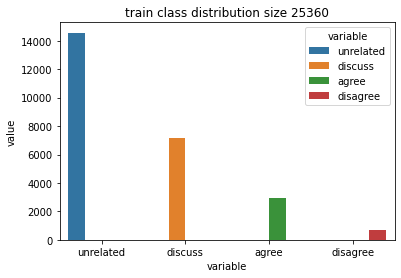

In [44]:
# distribution of labels (class distribution)
def dist_of(df):
    class_distribution = (pd.value_counts(df['Stance'])).to_dict()
    print(class_distribution)
    sns.barplot(data = pd.DataFrame.from_dict([class_distribution]).melt(), x = "variable", y="value", hue="variable").set_title(f'train class distribution size {len(df)}')

dist_of(data._target_df)

In [45]:
def sample(d):
    class_count = dict(pd.value_counts(d['Stance']))
    print(class_count)
    stance_map = {
        "agree": 0,
        "disagree": 1,
        "discuss": 2,
        "unrelated": 3
    }
    # fit the class count to sequence agree, disagree, discuss, unrelated
    cc = [0, 0, 0, 0]
    for key in class_count:
        cc[stance_map[key]] = class_count[key]

    weight = 1./torch.tensor(cc, dtype=torch.float).to(device)
    print(weight)
    
    # create array with weight for each data point
    target_list = [stance_map[(d.iloc[i]['Stance'])] for i in range(len(d))]
    samples_weight = torch.tensor([weight[t] for t in target_list]).to(device)

    weighted_sampler = WeightedRandomSampler(
        weights=samples_weight,
        num_samples=len(samples_weight),
        replacement=True
    )
    return weighted_sampler, weight

train_sampler, train_weights = sample(data._target_df)

{'unrelated': 14567, 'discuss': 7160, 'agree': 2951, 'disagree': 682}
tensor([3.3887e-04, 1.4663e-03, 1.3966e-04, 6.8648e-05])


### Step 3 - Define model & training

In [46]:
# hyperparameters
in_dim = 10001
hidden_dim = 100
out_dim = 4
epochs = 2 # 45
bs = 32 # batch size
lr = 0.001

In [47]:
# re-usable way to create dataloader
def make_batches(dataset, batch_size, shuffle=True, drop_last=True, sampler=None):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last, sampler=sampler)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict


In [48]:
# define neural net
class NN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(NN, self).__init__()

        # define layers
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_dim, out_dim)
    
    # applies layers with sample x
    def forward(self, x):
        out = self.l1(x).squeeze()
        out = self.relu(out)
        out = self.l2(out)
        return out

model = NN(in_dim, hidden_dim, out_dim).to(device)

criterion = nn.CrossEntropyLoss(weight=train_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [54]:
"""
TRAIN function
"""

# setup
train_losses = []
train_accu = []

# data split & batch loader
data.set_split('train')

def train(epoch, data):
  print('\nEpoch : %d'%epoch)
  
  model.train()
  train_loader = make_batches(data, bs, shuffle=False, sampler=train_sampler)

  running_loss=0
  correct=0
  total=0
 
  for i, data in enumerate(train_loader):
    # zero gradients each batch
    optimizer.zero_grad()
    
    inputs = ((sample)['x_data']).float()
    labels = sample['y_target']

    # predict for batch
    outputs = model(inputs)

    # compute loss and gradients
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    # adjust weights
    loss.backward()
    optimizer.step()

    # -----
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
       
  train_loss=running_loss/len(train_loader)
  accu=100.*correct/total
   
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [55]:
""" 
TEST function
"""

eval_losses=[]
eval_accu=[]

data.set_split('test')

def test(epoch, data):
  model.eval()

  # create batches for test dataset
  test_loader = make_batches(data, bs, shuffle=True)

  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for i, data in enumerate(test_loader):
      inputs = ((sample)['x_data']).float()
      labels = sample['y_target']
      
      outputs=model(inputs)
 
      loss = criterion(outputs, labels)
      running_loss+=loss.item()
       
   
  test_loss=running_loss/len(test_loader)
  accu=100.*correct/total
 
  eval_losses.append(test_loss)
  eval_accu.append(accu)
 
  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [56]:
epochs=2
for epoch in range(1,epochs+1): 
  train(epoch, data)
  #test(epoch)


Epoch : 1


IndexError: single positional indexer is out-of-bounds

In [25]:
"""
training loop
"""
loss_vals=  {}
loss_vals['train'] = []
loss_vals['test'] = []


for epoch in range(epochs):

    # setup
    data.set_split('train')
    train_loader = make_batches(data, bs, shuffle=False, sampler=train_sampler)

    running_loss = 0.
    last_loss = 0.
    epoch_loss = []

    # enumerate to track the batch index and do some intra-epoch reporting
    for i, sample in enumerate(train_loader):
        # zero gradients each batch
        optimizer.zero_grad()
        
        inputs = ((sample)['x_data']).float()
        labels = sample['y_target']

        # predict for batch
        outputs = model(inputs)

        # compute loss and gradients
        loss = criterion(outputs, labels)
        epoch_loss.append(loss.item())
        loss.backward()

        # adjust weights
        optimizer.step()

        # report
        running_loss += loss.item()
        if i % 100 == 0:
            last_loss = running_loss / 1000 # loss per batch
            print('Epoch {} batch {} loss: {}'.format(epoch + 1, i + 1, last_loss))
            running_loss = 0.
    
    # append avg loss per epoch to loss vals
    loss_vals['train'].append(sum(epoch_loss)/len(epoch_loss))

Epoch 1 batch 1 loss: 0.0013349539041519166


KeyboardInterrupt: 

In [ ]:


for epoch in range(epochs):

    # setup
    data.set_split('train')
    train_loader = make_batches(data, batch, shuffle=False, sampler=train_sampler)

    running_loss = 0.
    last_loss = 0.
    epoch_loss = []

for epoch in range(epochs):
    # setup
    data.set_split('test')
    test_loader = make_batches(data, batch)

    epoch_loss = []
    # accuracy
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        y_pred = []
        y_true = []
        for i, sample in enumerate(test_loader):
            
            inputs = ((sample)['x_data']).float()
            labels = sample['y_target']
            
            # test the trained model
            outputs = model(inputs)
            # get test epoch loss
            loss = criterion(outputs, labels)
            epoch_loss.append(loss.item())
            
            # value, index
            _, predictions = torch.max(outputs, 1)
            y_pred.extend(predictions.data.cpu().numpy())
            y_true.extend(labels.data.cpu().numpy())

            n_samples += labels.shape[0] # gives us n of samples of current batch
            n_correct += (predictions == labels).sum().item()

        
        # accuracy in percent
        # acc = 100.0 * n_correct / n_samples
        # print(f'accuracy = {acc}')
    
        # append avg loss per epoch to loss vals
        print(epoch_loss, 'end')
        loss_vals['test'].append(sum(epoch_loss)/len(epoch_loss))




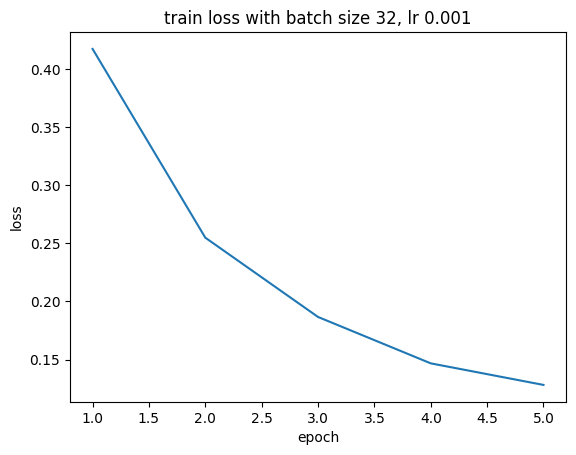

In [26]:
# plot loss once finished
def my_plot(epochs, loss):
    plt.plot(epochs, loss)
    plt.title(f'train loss with batch size {batch}, lr {lr}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
# plot loss when finished
my_plot(np.linspace(1, epochs, epochs).astype(int), loss_vals['train'])

In [156]:
from sklearn.metrics import classification_report
 
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       773
           1       0.68      0.94      0.79       309
           2       0.91      0.90      0.90      1822
           3       0.97      0.92      0.94      3592

    accuracy                           0.90      6496
   macro avg       0.83      0.90      0.86      6496
weighted avg       0.91      0.90      0.91      6496



In [162]:
# save the model
torch.save(model.state_dict(), "./kowalsky_90_weighted_bigram.pth")

[[7.56097561e-01 1.18881119e-01 2.66963293e-02 6.74882629e-03]
 [1.39372822e-02 6.80652681e-01 5.56173526e-04 1.17370892e-03]
 [9.17537747e-02 6.75990676e-02 9.07119021e-01 2.43544601e-02]
 [1.38211382e-01 1.32867133e-01 6.56284761e-02 9.67723005e-01]]


<AxesSubplot:title={'center':'cf matrix of testadata size 6508, lr: 0.001, batches: 32, epochs: 30'}>

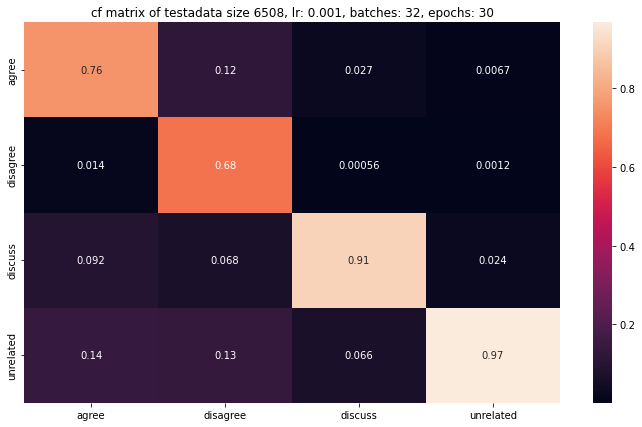

In [161]:
# confusion matrix
classes = ['agree', 'disagree', 'discuss', 'unrelated']

# Build confusion matrix (normalized as precision)
cf_matrix = confusion_matrix(y_true, y_pred, normalize='pred')
# precision, is in a sense correctness, and recall is completeness.

print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title(f'cf matrix of testadata size {len(data._target_df)}, lr: {lr}, batches: {batch}, epochs: {epochs}')
sns.heatmap(df_cm, annot=True)